In [2]:
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
lstm = pd.read_csv('lstm_forecast.csv')
mc = pd.read_csv('montecarlo_forecast.csv')
prophet = pd.read_csv('prophet_forecast.csv')

In [4]:
lstm

,date,forecast
0,2025-01-01,589.89
1,2025-02-01,592.77
2,2025-03-01,596.77
3,2025-04-01,602.23
4,2025-05-01,607.70
...,...,...
235,2044-08-01,3542.59
236,2044-09-01,3569.03
237,2044-10-01,3596.56
238,2044-11-01,3624.85


In [5]:
mc

,date,forecast
0,2024-12-06,604.546393
1,2024-12-07,605.701996
2,2024-12-08,607.023765
3,2024-12-09,606.507524
4,2024-12-10,606.604195
...,...,...
7295,2044-11-26,2416.756437
7296,2044-11-27,2430.716425
7297,2044-11-28,2438.473306
7298,2044-11-29,2425.305656


In [6]:
prophet

,date,forecast
0,2025-01-01,526.168713
1,2025-01-02,526.322720
2,2025-01-03,526.495145
3,2025-01-04,527.366980
4,2025-01-05,527.519496
...,...,...
7268,2044-11-25,1429.648352
7269,2044-11-26,1430.427694
7270,2044-11-27,1430.481839
7271,2044-11-28,1429.946874


In [7]:
intm  = lstm.merge(prophet, how='inner', left_on = 'date', right_on = 'date')
final = intm.merge(mc, how='inner', left_on = 'date', right_on = 'date')
final

,date,forecast_x,forecast_y,forecast
0,2025-01-01,589.89,526.168713,615.060052
1,2025-02-01,592.77,530.369617,630.173030
2,2025-03-01,596.77,532.798527,635.592815
3,2025-04-01,602.23,536.329760,628.693135
4,2025-05-01,607.70,540.241387,624.216376
...,...,...,...,...
234,2044-07-01,3516.17,1409.629838,2369.507186
235,2044-08-01,3542.59,1414.732165,2338.838163
236,2044-09-01,3569.03,1418.207980,2345.894426
237,2044-10-01,3596.56,1419.334897,2356.153025


In [8]:
final['forecast'] = 1/3 * (final['forecast'] + final['forecast_x'] + final['forecast_y'])
final.drop(columns=['forecast_x', 'forecast_y'], inplace = True)
final['date'] = pd.to_datetime(final['date'])

In [9]:
final

,date,forecast
0,2025-01-01,577.039589
1,2025-02-01,584.437549
2,2025-03-01,588.387114
3,2025-04-01,589.084298
4,2025-05-01,590.719254
...,...,...
234,2044-07-01,2431.769008
235,2044-08-01,2432.053443
236,2044-09-01,2444.377469
237,2044-10-01,2457.349307


In [30]:
initial_investment = 10_000

invspy_single = [initial_investment]

for i in range(1, len(final)):
    growth_factor = final['forecast'].iloc[i] / final['forecast'].iloc[i - 1]
    new_value = invspy_single[-1] * growth_factor
    invspy_single.append(new_value)

final_portfolio_value_single = invspy_single[-1]

print(f"Portfolio Value in December 2044 (Single Investment): ${final_portfolio_value_single:,.2f}")

Portfolio Value in December 2044 (Single Investment): $42,842.88


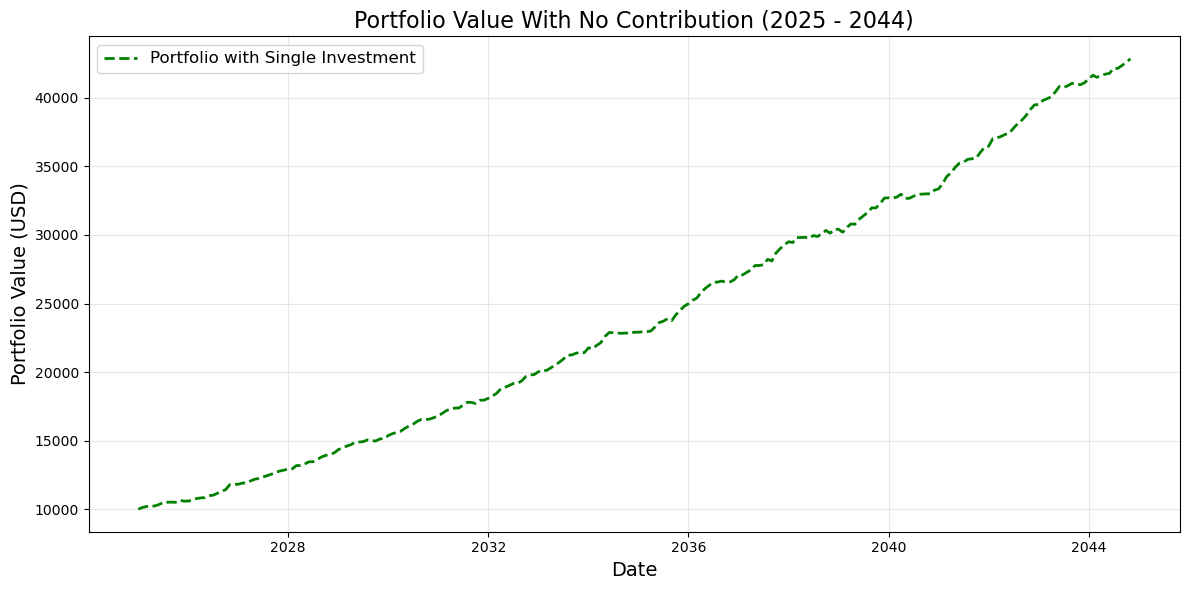

In [11]:
plt.figure(figsize=(12, 6))

plt.plot(final['date'], invspy_single, label="Portfolio with Single Investment", color='green', linestyle='--', linewidth=2)

plt.title("Portfolio Value With No Contribution (2025 - 2044)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value (USD)", fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
contribution_schedule = {
    '2025-01-01': 500,
    '2027-01-01': 1000,
    '2029-01-01': 1500,
    '2031-01-01': 2000
}

contribution_schedule = {pd.to_datetime(date): amount for date, amount in contribution_schedule.items()}

# Portfolio value tracker
invspy_dca = [initial_investment]

# Loop through forecasted data
for i in range(1, len(final)):
    date = final['date'].iloc[i]
    previous_value = invspy_dca[-1]
    
    growth_factor = final['forecast'].iloc[i] / final['forecast'].iloc[i - 1]
    new_value = previous_value * growth_factor  
    
    additional_contribution = sum(amount for contrib_date, amount in contribution_schedule.items() if contrib_date <= date)
    new_value += additional_contribution  #
    
    invspy_dca.append(new_value)

final_portfolio_value = invspy_dca[-1]

print(f"Portfolio Value in December 2044: ${final_portfolio_value:,.2f}")

Portfolio Value in December 2044: $1,735,124.27


In [13]:
total_contributions = 0
current_contribution = contribution_schedule[min(contribution_schedule.keys())]  # Start with the first contribution

for i in range(1, len(final)):
    date = final['date'].iloc[i]
    total_contributions += current_contribution
    
    # Update contribution amount based on schedule
    for start_date, contribution in contribution_schedule.items():
        if date >= pd.to_datetime(start_date):
            current_contribution = contribution

total_invested = total_contributions + initial_investment

print(f"Total Amount Invested: ${total_invested:,.2f}")

Total Amount Invested: $414,000.00


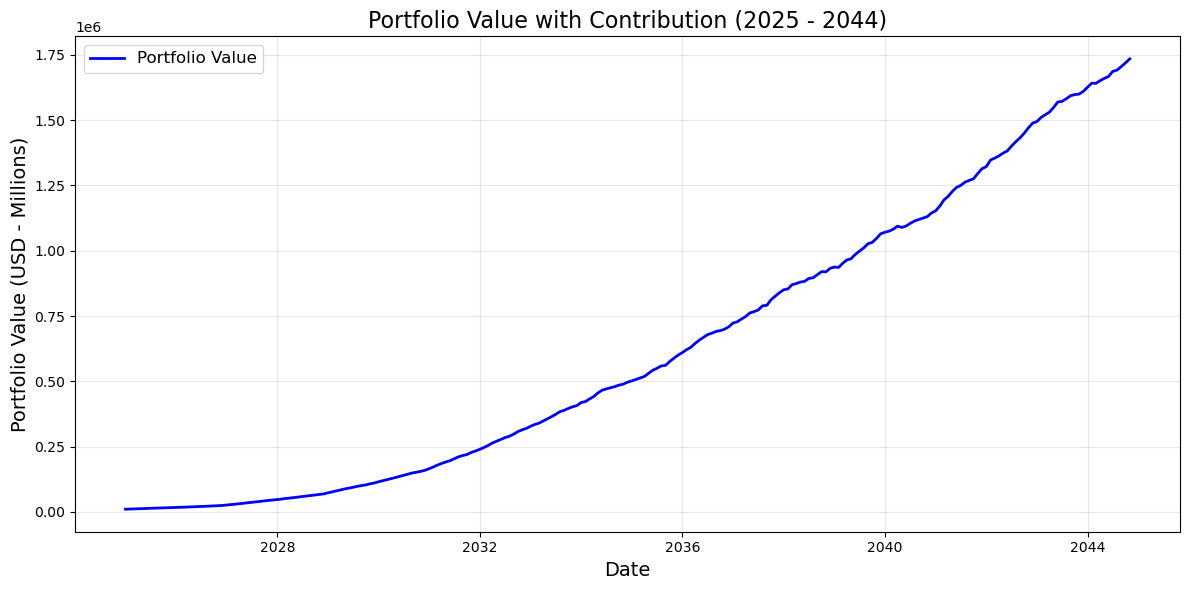

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(final['date'], invspy_dca, label="Portfolio Value", color='blue', linewidth=2)

plt.title("Portfolio Value with Contribution (2025 - 2044)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Portfolio Value (USD - Millions)", fontsize=14)

plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()